# Free Surface from Directional Spectra

In [1]:
import os
import os.path as op
import sys

# arrays
import numpy as np
import xarray as xr

# plots
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# span HTML width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# time
import time
import progressbar

# panel interaction
import panel as pn
pn.extension() # this is very important for notebook display

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies
from lib.surface import *

In [2]:
spectra = xr.Dataset({'dir': np.linspace(0,360, 24), 'freq':np.linspace(1/30, 1/2, 29)})
dirs = spectra.dir
freqs = spectra.freq

In [3]:
def plot_spectrum_freesurface(
    sea_hs=None, swell1_hs=None, swell2_hs=None,
    sea_tp=None,  swell1_tp=None,   swell2_tp=None,
    sea_dir=None, swell1_dir=None, swell2_dir=None,
    sea_spr=18, swell1_spr=10,  swell2_spr=12,
    sea_gamma=1, swell1_gamma=1, swell2_gamma=1,
    x_y_dist=2000, x_y_nodes=200, partitions=default_partitions):
    
    """
    This function is used to plot the panel
    
    """
    
    if True:
        
        # calculate the spectrum and the free surface
        spectrum = calculate_spectrum(
            freqs, dirs,
            partitions = {
                'sea':    (sea_hs, sea_tp, sea_dir, sea_spr, sea_gamma), # hs, tp, dir, spr, gamma
                'swell1': (swell1_hs, swell1_tp, swell1_dir, swell1_spr, swell1_gamma),
                'swell2': (swell2_hs, swell2_tp, swell2_dir, swell2_spr, swell2_gamma)
                # 'swell3': [...] ; add extra partitions as required...
            }
        ) # this is the customized spectrum  
        
        surface = calculate_surface(freqs, dirs,
            spectrum=spectrum, x_y_dist=x_y_dist,x_y_nodes=x_y_nodes,
            time=(1,1) # this indicates just one time will be calculated
        ) # this is the free surface
        
        # plot the spectrum and surface elevation
        cmap_spec = ListedColormap(
            np.vstack(
                (np.array([0,0,0,0]).reshape(1,-1),
                (cm.get_cmap('CMRmap_r', 124)(np.linspace(0.3, 0.97, 20)))
            )), name='spectrum'
        ) # spectrum colormap
        cmap_surf = ListedColormap(
            cm.get_cmap('YlGnBu_r',124)(np.linspace(0.0,0.8,20)),name='surface'
        ) # surface colormap

        fig = plt.figure(figsize=(19,7)) # this will be the figsize

        # spectrum axis
        ax_spec = plt.subplot(1,2,1,projection='polar')
        ax_spec.set_theta_zero_location('N',offset=0)
        ax_spec.set_theta_direction(-1)
        ax_spec.set_ylim(0,0.3)
        
        # surface axis
        ax_surf = plt.subplot(1,2,2)
        ax_surf.set_aspect('equal', adjustable='box')
        spec = ax_spec.pcolormesh(
            dirs.values*np.pi/180,freqs.values,
            spectrum.efth.values, cmap='CMRmap_r',
            shading='auto',
            vmin=0.0,vmax=0.5 # to mantain same ranges
        )

        xy = np.linspace(0, x_y_dist, len(surface.x.values))
        surf = ax_surf.pcolor(
            xy, xy,
            surface.values,cmap=cmap_surf,
            shading='auto'
        )
        
        # colorbars
        cax = fig.add_axes([0.48, 0.15, 0.02, 0.7])
        cb = fig.colorbar(spec, cax=cax, label='efth $(m^{2}/Hz/deg)$')

        ax_divider1 = make_axes_locatable(ax_surf)
        cax1 = ax_divider1.append_axes("right", size="7%", pad="2%")
        cb1 = fig.colorbar(surf, cax=cax1, label = '$\eta (m)$')
        
        # axis attrs
        ax_surf.set_xlim(0,x_y_dist), ax_surf.set_ylim(0,x_y_dist)
        ax_surf.set_xlabel('X (m)')
        ax_surf.set_ylabel('Y (m)')
        plt.close()

        return(fig)
    
    else:
        
        # calculate the free surface elevation for t times
        surfaces = calculate_surface(freqs, dirs,
            spectrum=spectrum, x_y_dist=x_y_dist, x_y_nodes=x_y_nodes,
            time=(30,2) # this indicates the time frames
        ) 
        
        return(surfaces)
    
kw = dict(
    sea_hs=(0, 10, 1, 2),       swell1_hs=(0, 10, 1, 0),        swell2_hs=(0, 10, 1, 0),
    sea_tp=(0, 26, 2, 8),        swell1_tp=(0, 26, 2, 14),      swell2_tp=(0, 26, 2, 14),
    sea_dir=(0, 360, 10, 0),     swell1_dir=(0, 360, 10, 90),    swell2_dir=(0, 360, 10, 180),
    sea_spr=(10, 50, 5, 20),     swell1_spr=(10, 50, 5, 10),      swell2_spr=(10, 50, 5, 10),
    sea_gamma=(1, 50, 1, 1),  swell1_gamma=(1, 50, 1, 20), swell2_gamma=(1, 50, 1, 20),
    x_y_dist=(500, 8000, 500),  x_y_nodes=(200, 800, 50, 400)
)
i = pn.interact(plot_spectrum_freesurface, **kw)

In [4]:
panel = pn.Column(

    pn.Row(
        i[0][0],i[0][3],i[0][6],i[0][9],i[0][12], 
    ),
    pn.Row(
        i[0][1],i[0][4],i[0][7],i[0][10],i[0][13]
    ),
    pn.Row(
        i[0][2],i[0][5],i[0][8],i[0][11],i[0][14]
    ),
    pn.Row(
        i[0][15],i[0][16], # we can also add some text
        '    -- These two are the distance and the number of pixels in the free surface image'
    ),
    pn.Row(i[1])
)

Column
    [0] Row
        [0] IntSlider(end=10, name='sea_hs', value=2)
        [1] IntSlider(end=26, name='sea_tp', step=2, value=8)
        [2] IntSlider(end=360, name='sea_dir', step=10)
        [3] IntSlider(end=50, name='sea_spr', start=10, step=5, value=18)
        [4] IntSlider(end=50, name='sea_gamma', start=1, value=1)
    [1] Row
        [0] IntSlider(end=10, name='swell1_hs')
        [1] IntSlider(end=26, name='swell1_tp', step=2, value=14)
        [2] IntSlider(end=360, name='swell1_dir', step=10, value=90)
        [3] IntSlider(end=50, name='swell1_spr', start=10, step=5, value=10)
        [4] IntSlider(end=50, name='swell1_gamma', start=1, value=1)
    [2] Row
        [0] IntSlider(end=10, name='swell2_hs')
        [1] IntSlider(end=26, name='swell2_tp', step=2, value=14)
        [2] IntSlider(end=360, name='swell2_dir', step=10, value=180)
        [3] IntSlider(end=50, name='swell2_spr', start=10, step=5, value=12)
        [4] IntSlider(end=50, name='swell2_gamma', start=1, value=1)
    [3] Row
        [0] IntSlider(end=8000, name='x_y_dist', start=500, step=500, value=2000)
        [1] IntSlider(end=800, name='x_y_nodes', start=200, step=50, value=200)
        [2] Markdown(str)
    [4] Row
        [0] Row
            [0] Matplotlib(Figure, name='interactive00101')
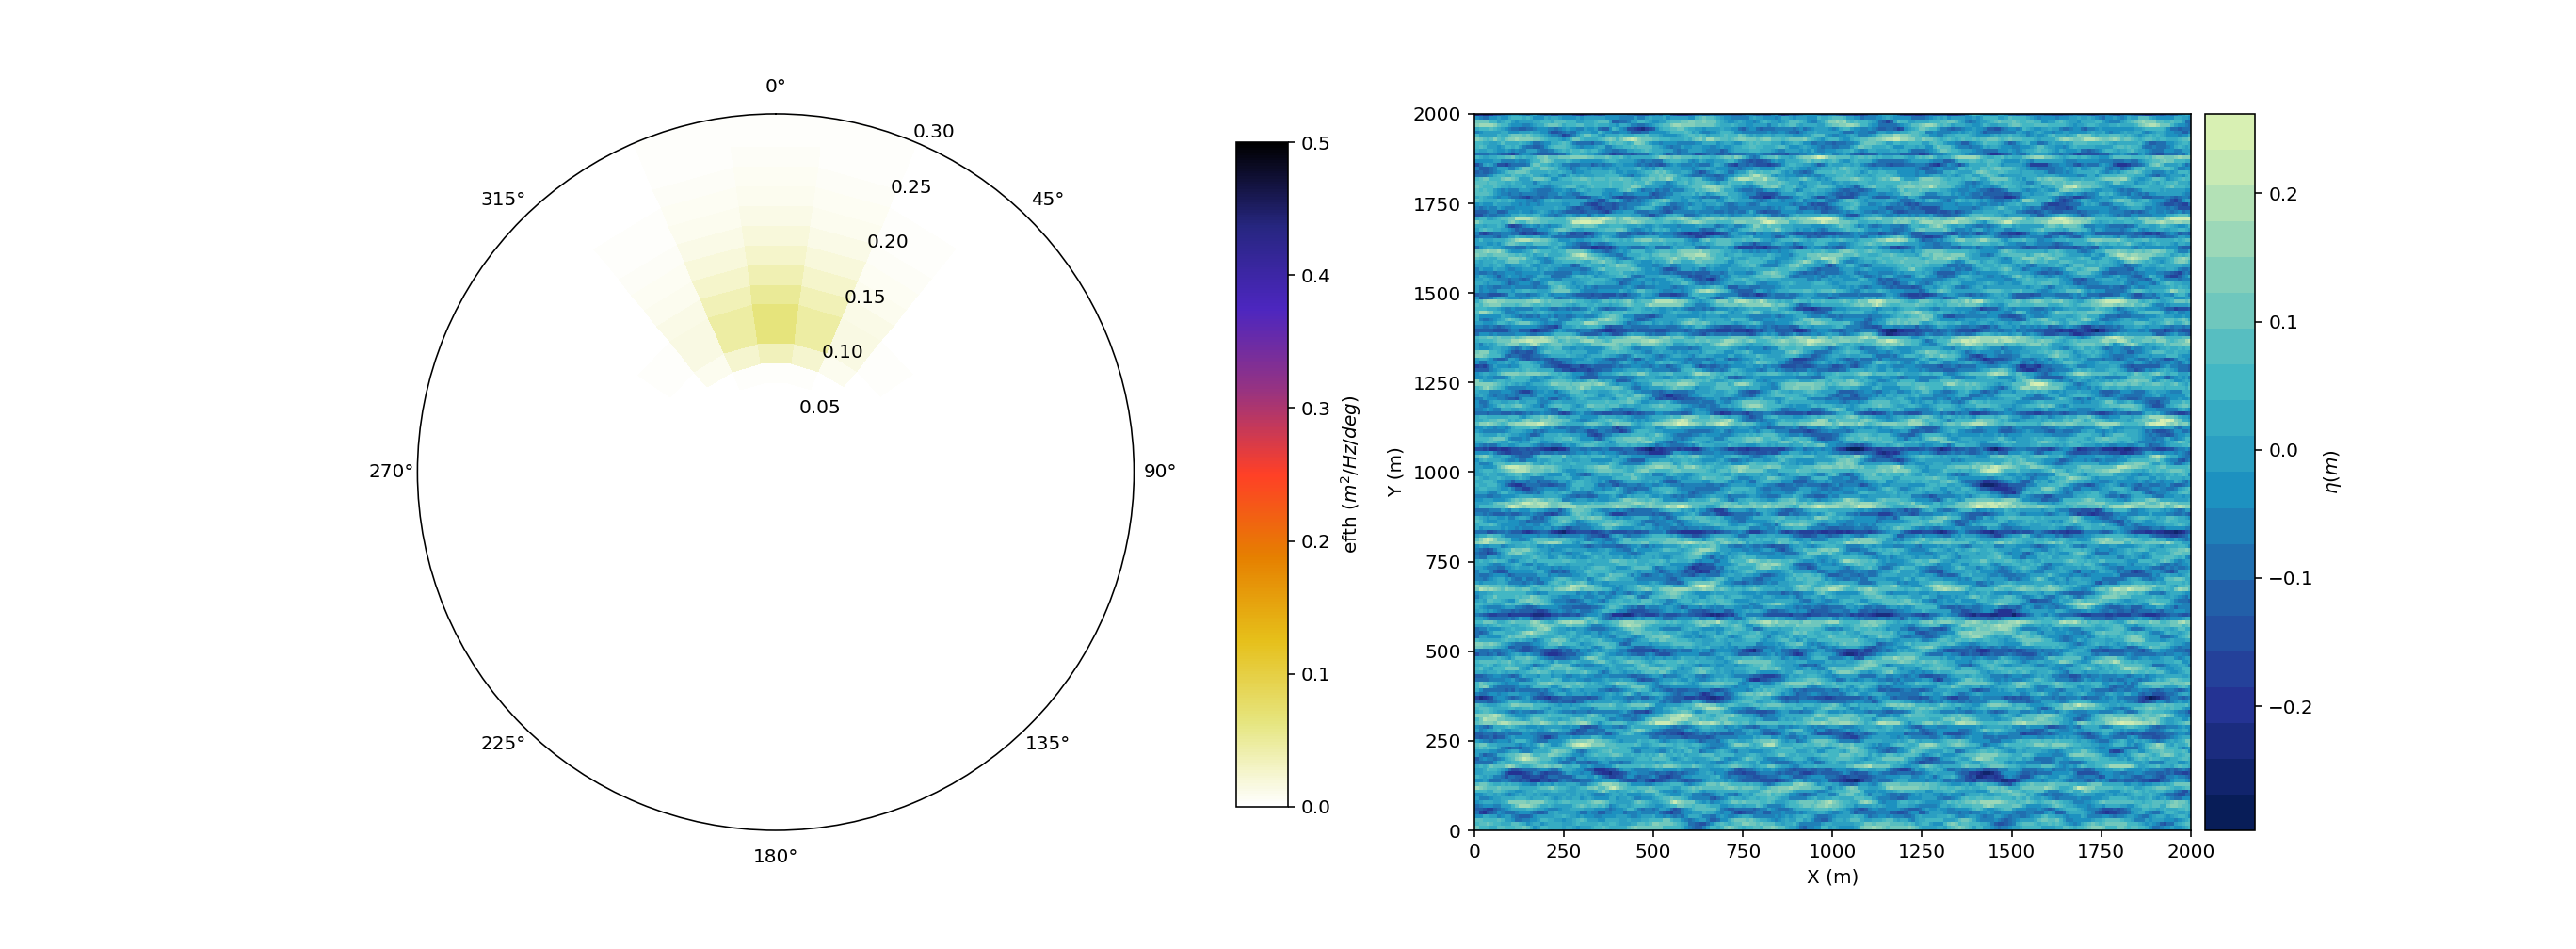

In [5]:
# panel
panel